In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import open_clip
import random
import os
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Load the BiomedCLIP model and preprocess functions
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Load tokenizer 
tokenizer = open_clip.get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

G:\anaconda3\envs\MEDCAT\Lib\site-packages\open_clip\factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_

In [3]:
# Function to load image features and caption features
def load_image_and_caption_features(image_folder, caption_file, model, preprocess_val, tokenizer, device, context_length=256):
    # Load the dataset
    caption_df = pd.read_csv(caption_file)
    
    # Create paths for images
    caption_df['Image'] = caption_df['Image'].apply(lambda x: os.path.join(image_folder, x))
    
    # Preprocess images and captions
    images = torch.stack([preprocess_val(Image.open(img)) for img in caption_df['Image']]).to(device)
    captions = tokenizer(caption_df['Caption'].tolist(), context_length=context_length).to(device)

    # Extract features
    with torch.no_grad():
        image_features, caption_features, _ = model(images, captions)
    
    # Move tensors to CPU and convert to numpy arrays
    image_features_np = image_features.cpu().numpy()
    caption_features_np = caption_features.cpu().numpy()

    return caption_df, image_features_np, caption_features_np
    
def display_images_with_captions(df):
    for index, row in df.iterrows():
        img_path = row['Image']  # Get the image path directly from the DataFrame
        img = Image.open(img_path)  # Open the image

        plt.figure(figsize=(5, 5))  # Set the figure size
        plt.imshow(img)  # Display the image
        plt.title(f"Caption: {row['Caption']}", fontsize=12)  # Set the title to the caption
        plt.axis('off')  # Hide the axes
        plt.show()  # Show the image
        
# Function to retrieve top 5 similar samples
def retrieve_top_k_similar(query, query_type, model, preprocess_val, tokenizer, image_folder, caption_file, k=5):
    # Load dataset features
    caption_df, image_features_np, caption_features_np = load_image_and_caption_features(image_folder, caption_file, model, preprocess_val, tokenizer, device)

    # Check if query is an image or caption
    if query_type == 'image':
        # Preprocess the query image
        query_image = preprocess_val(Image.open(query)).unsqueeze(0).to(device)
        
        # Extract features for the query image
        with torch.no_grad():
            query_image_features = model.encode_image(query_image).cpu().numpy()
        
        # Calculate cosine similarity with dataset image features
        similarities = cosine_similarity(query_image_features, image_features_np)[0]

    elif query_type == 'caption':
        # Tokenize the query caption
        query_caption = tokenizer([query], context_length=256).to(device)
        
        # Extract features for the query caption
        with torch.no_grad():
            query_caption_features = model.encode_text(query_caption).cpu().numpy()
        
        # Calculate cosine similarity with dataset caption features
        similarities = cosine_similarity(query_caption_features, caption_features_np)[0]

    else:
        raise ValueError("query_type should be 'image' or 'caption'.")

    # Get top k most similar indices
    top_k_indices = np.argsort(similarities)[-k:][::-1]

    # Return top k most similar samples
    result = caption_df.iloc[top_k_indices], similarities[top_k_indices]
    printable_df, image_scores = result
    print("Top similar "+query_type+": ")
    display_images_with_captions(printable_df)
    return result




In [4]:
# Example usage
image_folder = r'G:\USER\Documents\GitHub\QL4POMR\Datasets\Paper Samples\Samples\Images'
caption_file = r'G:\USER\Documents\GitHub\QL4POMR\Datasets\Paper Samples\Samples\Samples.csv'


G:\anaconda3\envs\MEDCAT\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(


Top similar image: 


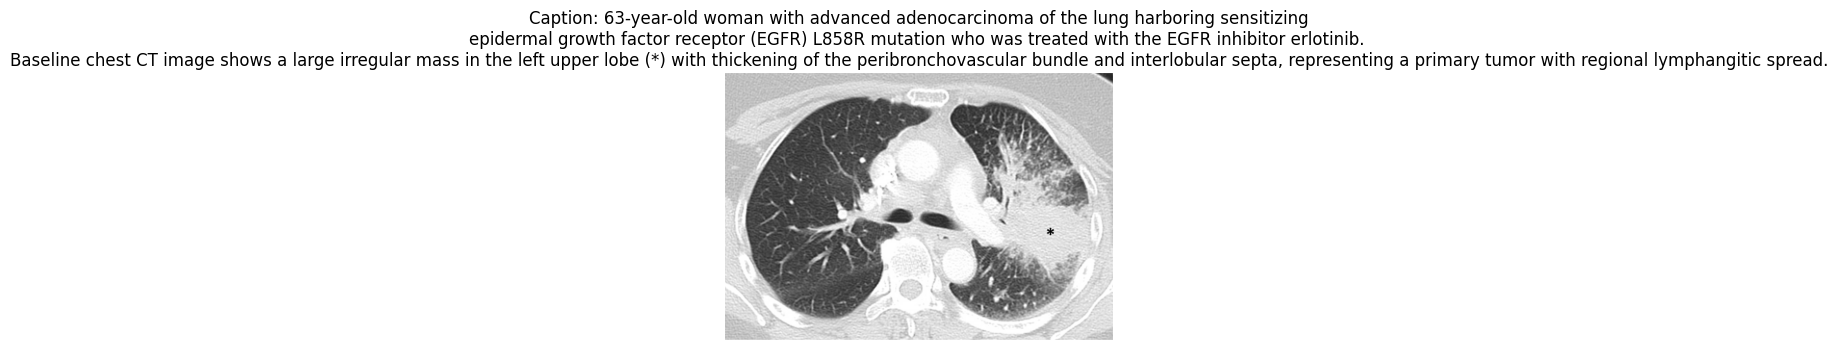

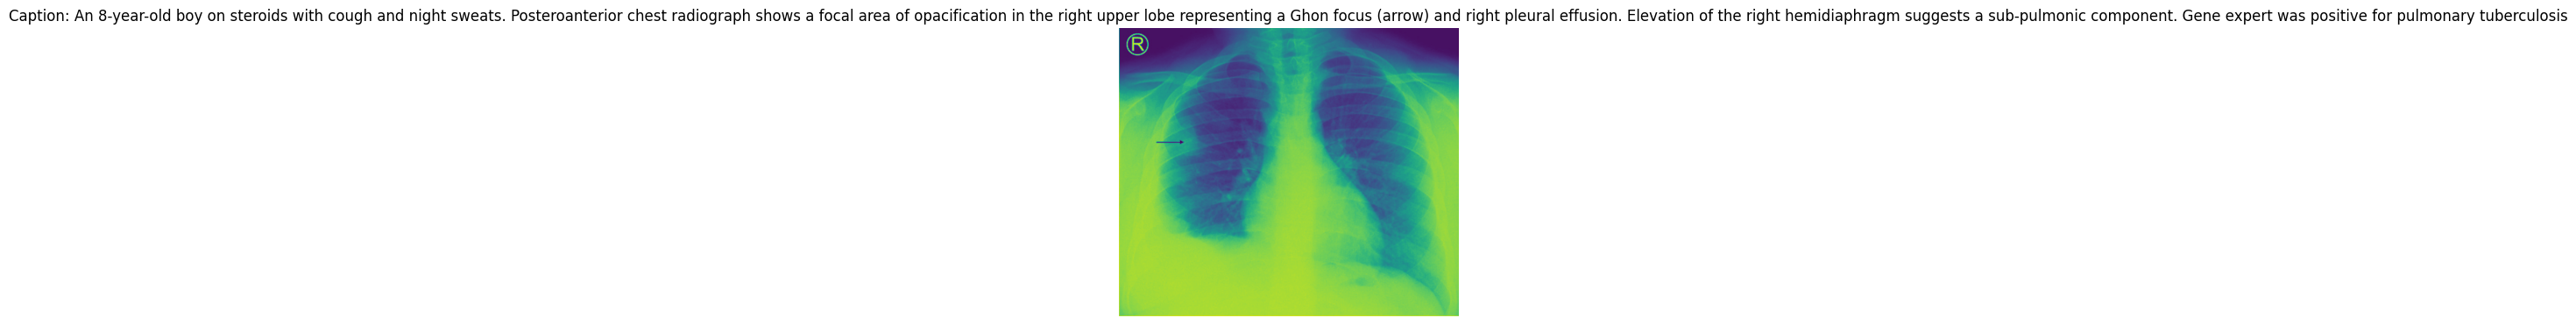

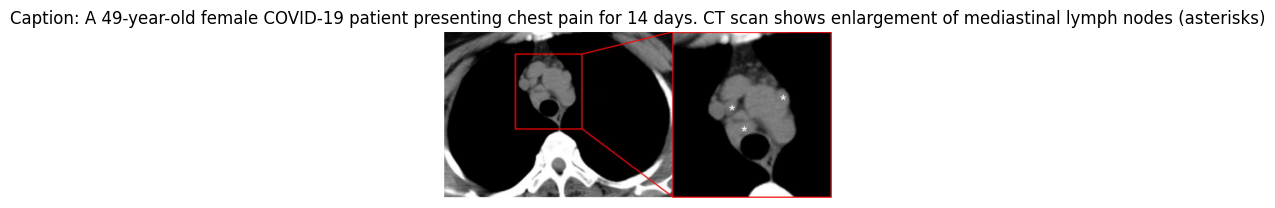

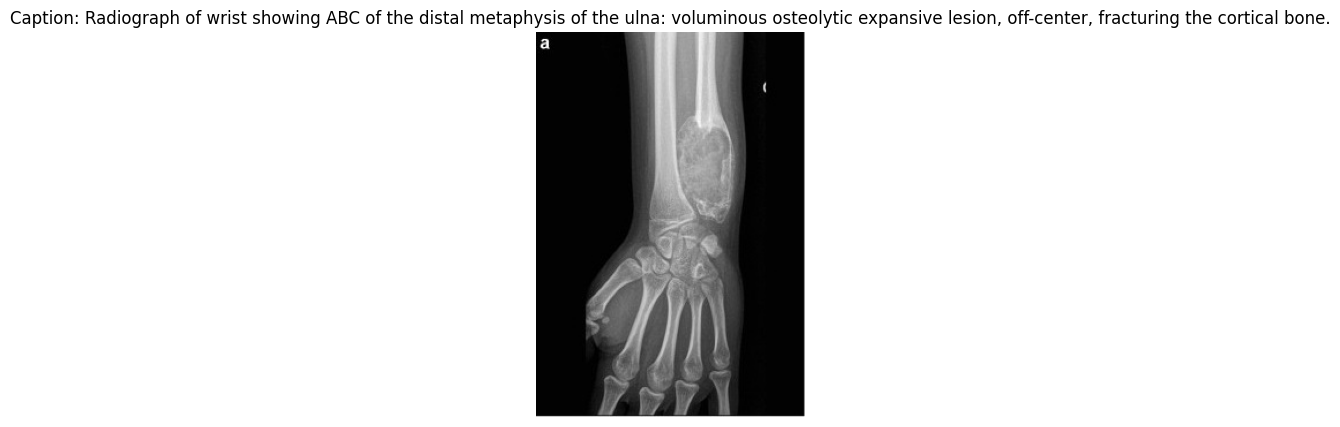

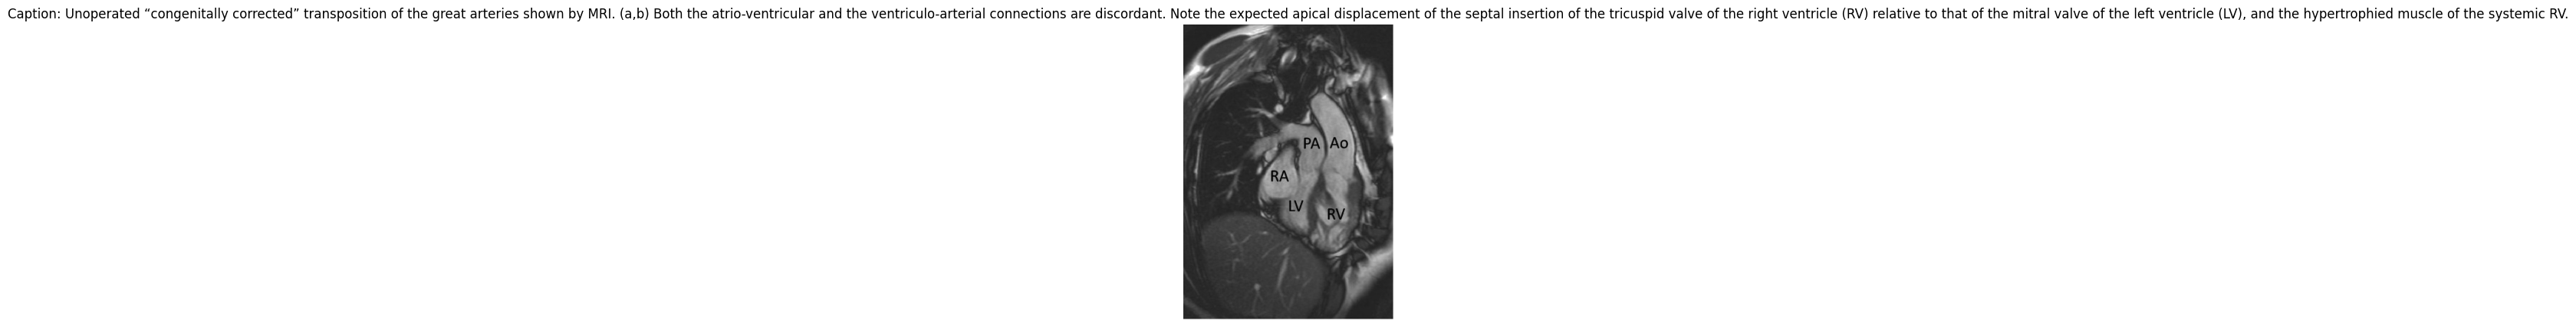

In [5]:
# Use the first image and caption from the dataset as input for the similarity retrieval

# Extract the first image path and first caption from the DataFrame
first_image_path = os.path.join(image_folder, "test sample.png") 
first_caption = "Lung adenocarcinoma presenting as a dense pneumonic consolidation with mediastinal infiltration, lymphadenopathy and lung metastases."

# Perform retrieval for image query
top_similar_images, image_scores = retrieve_top_k_similar(first_image_path, 'image', model, preprocess_val, tokenizer, image_folder, caption_file)

Top similar caption: 


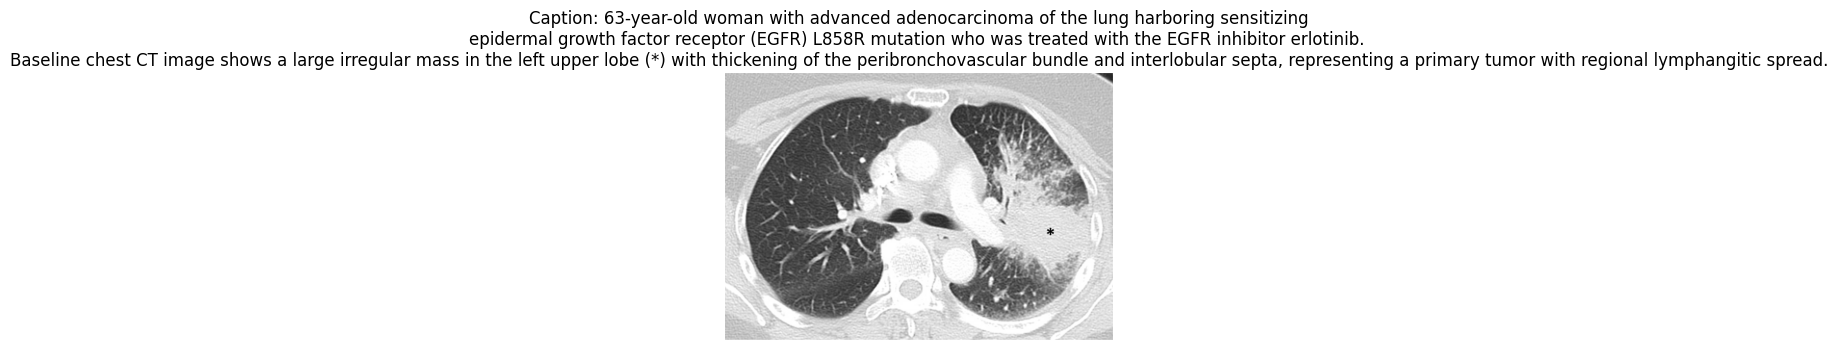

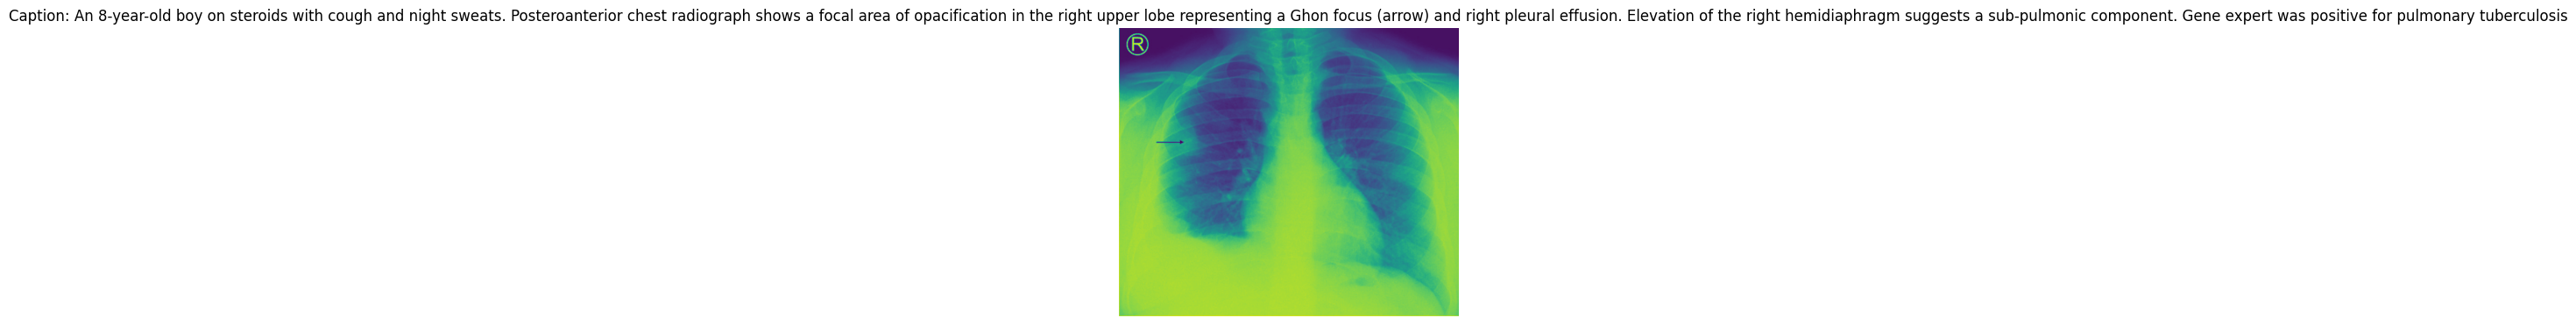

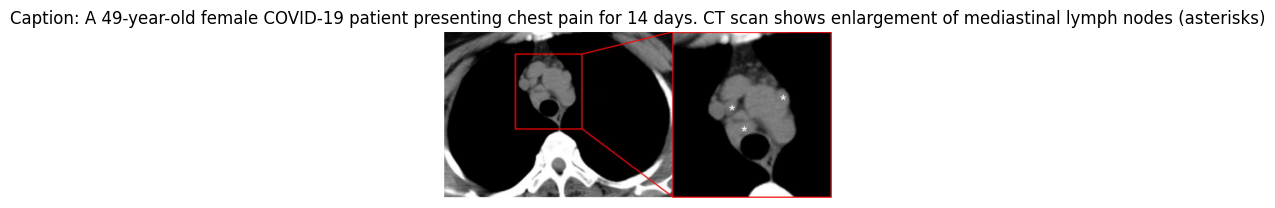

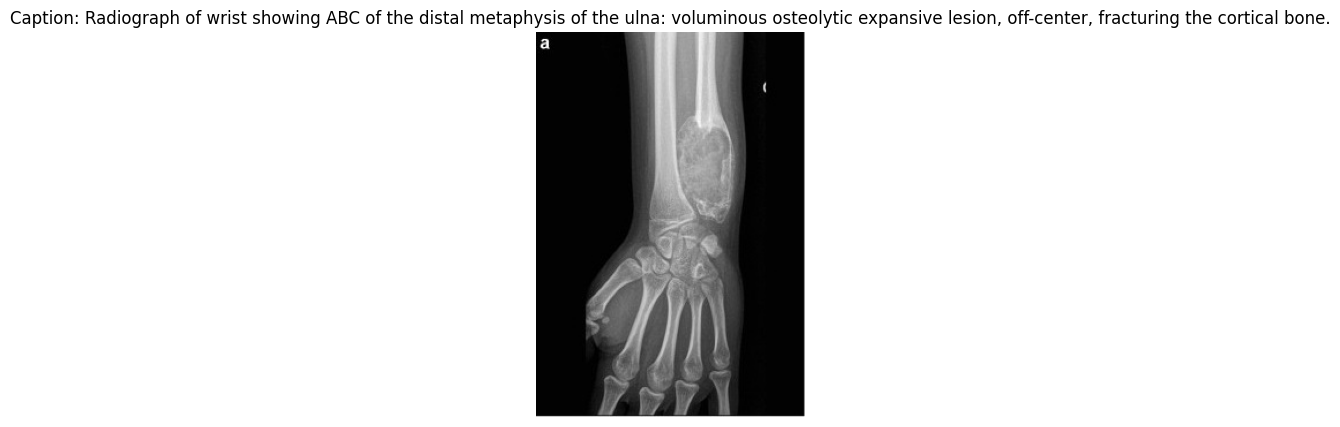

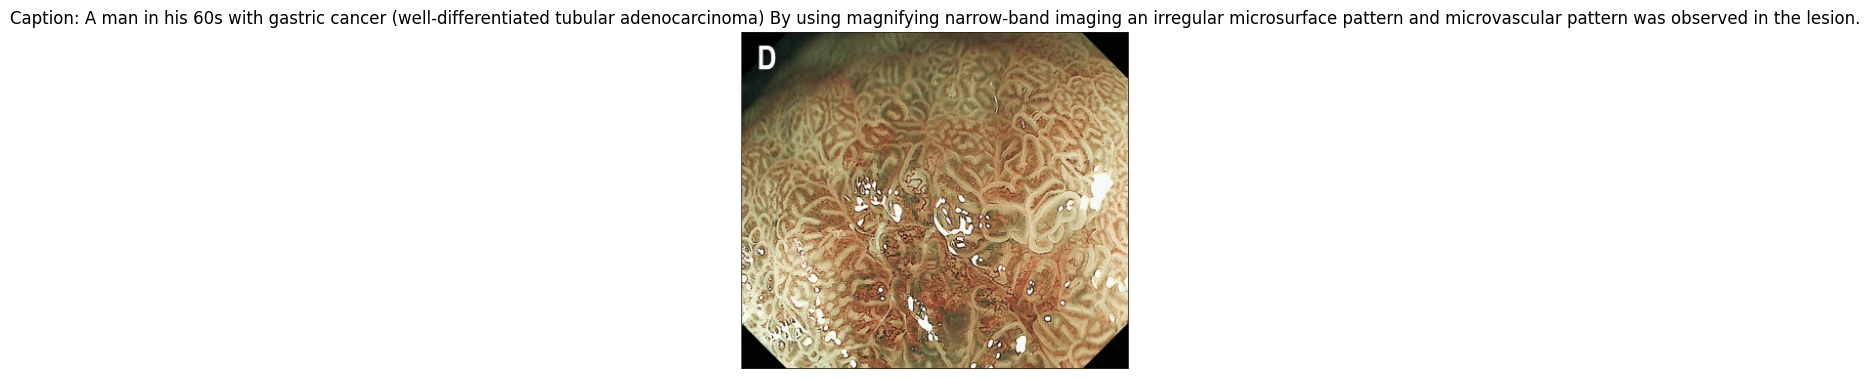

In [6]:
# Perform retrieval for caption query
top_similar_captions, caption_scores = retrieve_top_k_similar(first_caption, 'caption', model, preprocess_val, tokenizer, image_folder, caption_file)